<a href="https://colab.research.google.com/github/gopaps/MachineLearning/blob/main/week%2015/Anda_Figo_Haq_tuning_Vision_Transformers_for_Object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning Vision Transformers for Object Detection

Welcome to the HuggingFace 🤗 Community Course Unit 3, Chapter 3; Transfer-Learning and Fine-tuning Vision Transformers. In this part, we will understand more on how we can fine-tune an existing Vision Transformer model for Object Detection. Before getting started, check out this HuggingFace Space, where you can play around with the final output.

```
<iframe
	src="https://huggingface.co/spaces/hf-vision/finetuning_demo_for_object_detection"
	frameborder="0"
	width="850"
	height="450">
</iframe>
```

Also there is a small section if you are interested in Transfer learning instead of fine tuning only.

## Introduction

![intro](https://huggingface.co/datasets/hf-vision/course-assets/resolve/main/object_detection_wiki.png)

Object detection is a computer vision task aims at identifying and localizing objects within an image or video. It involves two primary steps:

1. first, recognizing the types of objects present (such as cars, people, or animals).
2. Second, determining their precise locations by drawing bounding boxes around them.

The input to these models are often an image (static or a video frame) containing multiple objects. Example: An image containing objects like a car, a person, a cycle etc. The output of these models are simply some set of numbers, which tells us the following:

1. Where the object is located? (regressive output containing co-ordinates of the bounding box)
2. What is that object? (classification)

There are huge number of applications around object detection. One most significant example being in the fields of autonomous driving. Where Object detection is used to detect different objects (like pedestrians, road signs, and traffic lights etc)  around the car that becomes one of the input for taking decisions.

If you want to understand more around the ins-and-outs of object detection, check out our [dedicated chapter](#) on Object Detection 🤗

### Why do we need fine-tuning for object detection 🤔

That is an awesome question. Before reading the answer, checkout our definitions of fine-tuning and it's difference with transfer learning [here](#).

Training an object detection model from scratch means:

1. Doing already done research over and over again.
2. Writing repetitive model code and training them and maintaining different repositories for different use cases.
3. Lot of experimentation and waste of resources.

So, instead what we can do is, simply take a superstar pre-trained model (a model which does an awesome job in recognizing general features), and tweak or re-tune their weights (or some part of their weights) to adapt it for our use case. We believe or assume that, the pre-trained model has already learned enough to extract significant features inside an image to locate and classify objects. So, if new objects are introduced, then the same model can be trained for a small period of time and compute to start detecting those new objects with the help of already learned and new features.

### What to expect from this tutorial?

By the end of this tutorial, you should be able to make a full pipeline (from loading datasets, fine-tuning a model and doing inference) for object detection use case.

## Installation

Let's start with installation. Just execute the below cells to install the necessary packages. For this tutorial, we will be using Hugging Face 🤗 Transformers and PyTorch.

In [1]:
!pip install -U -q datasets transformers[torch] evaluate timm albumentations accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.9/274.9 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 17.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## Scenario

To make this tutorial interesting, let's consider a real-world example. Consider this scenario: construction workers require the utmost safety when working in construction areas. Basic safety protocol requires wearing them helmet every time. Since there are lot of construction workers, it is hard to keep and eye on everyone everytime.

But, if we can have a camera system, which can detect persons and whether the person is wearing a helmet or not in real time, that would be awesome, right?

So, we are going to fine-tune a light weight object detection model for doing the same. Let's dive in.


### Dataset

Keeping in mind for the above scenerio, we will be using the [hardhat](https://huggingface.co/datasets/hf-vision/hardhat) dataset provided by [Northeaster University China](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/7CBGOS). We will be using 🤗 `datasets` to download and load this dataset.

In [2]:
from datasets import load_dataset

dataset = load_dataset("anindya64/hardhat")
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/872 [00:00<?, ?B/s]

(…)-00000-of-00001-3e0d95da2811afee.parquet:   0%|          | 0.00/200M [00:00<?, ?B/s]

(…)-00000-of-00001-9fc2e7e45a21ae43.parquet:   0%|          | 0.00/66.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5297 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1766 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'image_id', 'width', 'height', 'objects'],
        num_rows: 5297
    })
    test: Dataset({
        features: ['image', 'image_id', 'width', 'height', 'objects'],
        num_rows: 1766
    })
})

In [3]:
dataset['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375>,
 'image_id': 1,
 'width': 500,
 'height': 375,
 'objects': {'id': [1, 1],
  'area': [3068.0, 690.0],
  'bbox': [[178.0, 84.0, 52.0, 59.0], [111.0, 144.0, 23.0, 30.0]],
  'category': ['helmet', 'helmet']}}

In [4]:
# extract out the train and test set

train_dataset = dataset['train']
test_dataset = dataset['test']

So, we have around 5000 training samples and 1700 test samples. Let's first see, how one sample of the dataset looks like:

In [5]:
sample = train_dataset[0]
sample

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375>,
 'image_id': 1,
 'width': 500,
 'height': 375,
 'objects': {'id': [1, 1],
  'area': [3068.0, 690.0],
  'bbox': [[178.0, 84.0, 52.0, 59.0], [111.0, 144.0, 23.0, 30.0]],
  'category': ['helmet', 'helmet']}}


1. `image`: This is a Pillow Image object that helps to look into the image directly before even loading from the path.
2. `image_id`: Denotes which number of image is from the train file.
3. `width`: The width of the image.
4. `height`: The height of the image.
5. `objects`:  Another dictionary containing information about annotation. This contains the following:
    1. `id`: A list, where length of list denotes the number of objects and value of each denotes the class index.
    2. `area`: The area of the object.
    3. `bbox`: Denotes bounding box coordinates of the object.
    4. `category`: The class (string) of the object.

Now, that we know what a sample data point contains, let's start with plotting that sample. Here we are going to first draw the image and then also draw the corresponding bounding box associated.

Here is what we are going to do:

1. Get the image and it's corresponding height and width.
2. Make a draw object that can easily draw text and lines on image.
3. Get the annotations dict from the sample.
4. Iterate over it.
5. For each, get the bounding box co-ordinates, which are x (where the bounding box starts horizontally), y (where the bounding box starts vertically), w (width of the bounding box), h (height of the bounding box).
6. Now if the bounding box measures are normalized then scale it, else leave it.
7. And finally draw the rectangle and the the class category text.

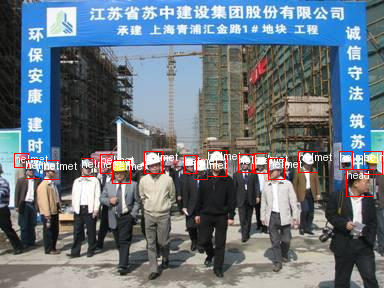

In [6]:
import numpy as np
from PIL import Image, ImageDraw

def draw_image_from_idx(dataset, idx):
    sample = dataset[idx]
    image = sample["image"]
    annotations = sample['objects']
    draw = ImageDraw.Draw(image)
    width, height = sample['width'], sample['height']

    for i in range(len(annotations["id"])):
        box = annotations["bbox"][i]
        class_idx = annotations["id"][i]
        x, y, w, h = tuple(box)
        if max(box) > 1.0:
            x1, y1 = int(x), int(y)
            x2, y2 = int(x + w), int(y + h)
        else:
            x1 = int(x * width)
            y1 = int(y * height)
            x2 = int((x + w) * width)
            y2 = int((y + h) * height)
        draw.rectangle((x1, y1, x2, y2), outline="red", width=1)
        draw.text((x1, y1), annotations["category"][i], fill="white")
    return image


draw_image_from_idx(dataset=train_dataset, idx=10)

In [7]:
# Now let's make a simple function on plotting multiple images

import matplotlib.pyplot as plt

def plot_images(dataset, indices):
    """
    Plot images and their annotations.
    """
    num_rows = len(indices) // 3
    num_cols = 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    for i, idx in enumerate(indices):
        row = i // num_cols
        col = i % num_cols

        # Draw image
        image = draw_image_from_idx(dataset, idx)

        # Display image on the corresponding subplot
        axes[row, col].imshow(image)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

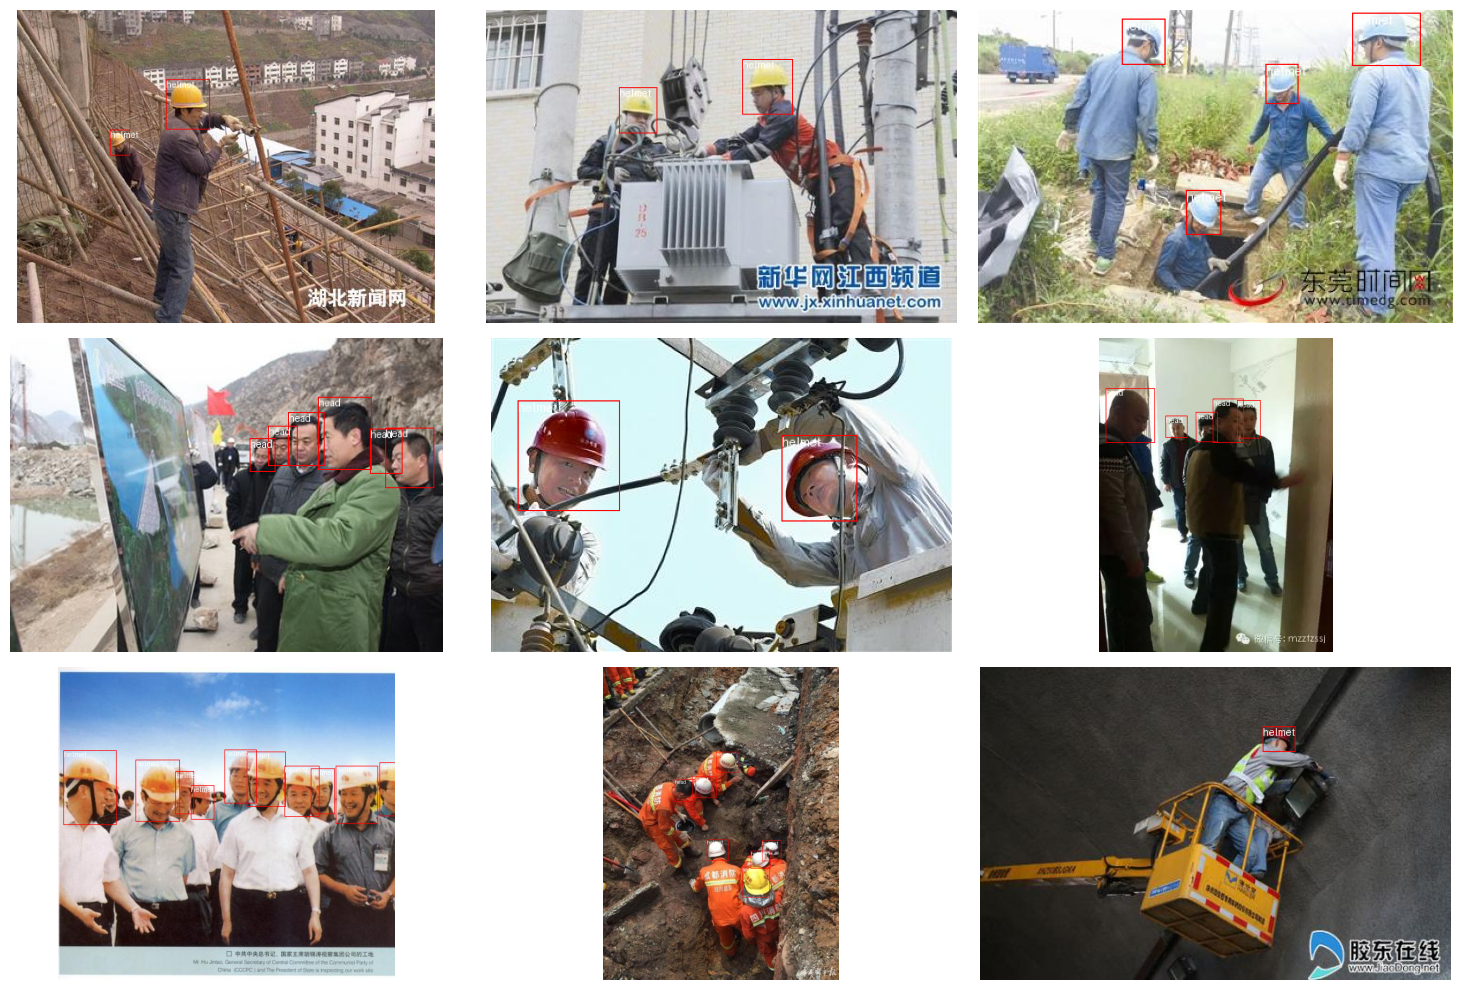

In [8]:
plot_images(train_dataset, range(9))

## AutoImageProcessor

Before fine-tuning the model, we must preprocess the data in such a way that it matches exactly with the approach it was used during the time if pre-training. HuggingFace [AutoImageProcessor](https://huggingface.co/docs/transformers/v4.36.0/en/model_doc/auto#transformers.AutoImageProcessor) takes care of processing the image data to create pixel_values, pixel_mask, and labels that a DETR model can train with.

Now, let us instantiate the image processor from the same checkpoint we want to use our model to fine-tune.

In [9]:
from transformers import AutoImageProcessor

checkpoint = "facebook/detr-resnet-50-dc5"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

preprocessor_config.json:   0%|          | 0.00/274 [00:00<?, ?B/s]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


## Preprocessing the dataset

In this section, we will preprocess the dataset. Basically, we will apply different types of augmentations to the images, along with their corresponding bounding boxes.

In simple terms, augmentations are some set of random transformations like rotations, resizing etc. These are applied for the following reasons:

1. To get more samples.
2. To make the vision model more robust towards different conditions of the image.

We will use the [albumentations](https://github.com/albumentations-team/albumentations) library to achieve this. If you want to dig deeper into different types of augmentations, check out the corresponding unit to learn more.

In [10]:
# now creating random augmentations using albumentations

import albumentations
import numpy as np
import torch

transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

Once we initialize all the transformations, we need to make a function which formats the annotations and returns the a list of annotation with a very specific format.

This is because, The `image_processor` expects the annotations to be in the following format: `{'image_id': int, 'annotations': List[Dict]}`, where each dictionary is a COCO object annotation.

In [11]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

Finally, we combine the image and annotation transformations to do transformations over the whole batch of dataset.

Here is the final code to do so:

In [12]:
sample

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375>,
 'image_id': 1,
 'width': 500,
 'height': 375,
 'objects': {'id': [1, 1],
  'area': [3068.0, 690.0],
  'bbox': [[178.0, 84.0, 52.0, 59.0], [111.0, 144.0, 23.0, 30.0]],
  'category': ['helmet', 'helmet']}}

In [13]:
train_dataset

Dataset({
    features: ['image', 'image_id', 'width', 'height', 'objects'],
    num_rows: 5297
})

In [14]:
# transforming a batch

def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["id"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

Now all you have to do is apply this preprocessing function to the entire dataset. You can achieve this by using HuggingFace 🤗 [Datasets with transform](https://huggingface.co/docs/datasets/v2.15.0/en/package_reference/main_classes#datasets.Dataset.with_transform) method.

In [15]:
# Apply transformations for both train and test dataset

train_dataset_transformed = train_dataset.with_transform(transform_aug_ann)
test_dataset_transformed = test_dataset.with_transform(transform_aug_ann)

We are almost there 🚀. As a last preprocessing step, we need to write a custom `collate_fn`. Now what is a `collate_fn` ?

A `collate_fn` is responsible for taking a list of samples from a dataset and converting them into a batch suitable for model's input format.

In general a `DataCollator` typically performs tasks such as padding, truncating etc. In a custom collate function, we often define what and how we want to group the data into batches or simply, how to represent each batch.

(BTW data collator is mainly puts the data together and then preprocesses them)

In [16]:
train_dataset_transformed[0]

{'pixel_values': tensor([[[-0.7822, -0.7822, -0.7822,  ..., -0.9534, -1.1075, -1.2103],
          [-0.7822, -0.7822, -0.7822,  ..., -0.9534, -1.1075, -1.2103],
          [-0.7822, -0.7822, -0.7993,  ..., -0.9705, -1.1247, -1.2274],
          ...,
          [-1.1247, -1.1932, -1.3130,  ..., -1.3644, -1.4158, -1.4500],
          [-1.1247, -1.1932, -1.3130,  ..., -1.3815, -1.4500, -1.4843],
          [-1.1247, -1.1932, -1.3130,  ..., -1.3987, -1.4672, -1.5014]],
 
         [[-0.7227, -0.7227, -0.7227,  ..., -0.5476, -0.7227, -0.8277],
          [-0.7227, -0.7227, -0.7227,  ..., -0.5651, -0.7402, -0.8452],
          [-0.7227, -0.7227, -0.7402,  ..., -0.5826, -0.7577, -0.8803],
          ...,
          [-0.7227, -0.8102, -0.9503,  ..., -1.0903, -1.1429, -1.1779],
          [-0.7227, -0.8277, -0.9678,  ..., -1.1078, -1.1604, -1.2129],
          [-0.7227, -0.8277, -0.9678,  ..., -1.1078, -1.1779, -1.2304]],
 
         [[-0.4275, -0.4275, -0.4275,  ...,  0.0779, -0.0964, -0.2010],
          [-

In [17]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

## How about Transfer learning ?

In this notebook , we primarily discussed about the fine-tuning a certain model to our custom dataset. What if , we only want transfer learning? Actually that is easy peasy! In transfer learning , we have to keep the parameter values aka weights, of the pretrained model frozen. We just train the classifier layer (in some cases, one or two more layers). In this case before starting the training process, we can do the following,

In [24]:
from transformers import AutoModelForObjectDetection

id2label = {0:'head', 1:'helmet', 2:'person'}
label2id = {v: k for k, v in id2label.items()}


model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

for name,p in model.named_parameters():
    if not 'bbox_predictor' in name or not name.startswith('class_label'):
        p.requires_grad = False

Some weights of the model checkpoint at facebook/detr-resnet-50-dc5 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model check

That means, after loading the model , we freeze all of the layers except last 6 layers. Which are `bbox_predictor.layers` and `class_labels_classifier`.